#### Single Trial Analysis 
##### New Bonsai NWBs

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import codeocean
from codeocean import CodeOcean 
import sys 
import pandas as pd
import os
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from datetime import datetime
import re
import glob

from aind_dynamic_foraging_data_utils import nwb_utils as nu
import aind_dynamic_foraging_basic_analysis.licks.annotation as a

sys.path.insert(1, '/root/capsule/code/utils')
import behavior_utils as bu
import array_utils as au
import data_utils as du 
import nwb_utils

In [3]:
data_folder = '/root/capsule/data/'
behavior_folder = '/root/capsule/data/foraging_nwb_bonsai'
master_df_path = '/root/capsule/data/df_processed_20241025.csv'

In [4]:
# No processed_CO_dataID, session_names

master_df = pd.read_csv(master_df_path)
filtered_df = du.filter_fiber_probes(master_df)
data_asset_IDs = du.get_processed_CO_dataID_for_stage(filtered_df, "STAGE_1")
session_names = du.get_processed_session_name_for_stage(filtered_df, "STAGE_1")
nwb_suffixes = du.get_nwb_suffix_for_stage(filtered_df, "STAGE_1")
formatted_suffixes = du.format_nwb_suffixes(nwb_suffixes)

In [5]:
data_assets = du.generate_data_asset_params(data_asset_IDs, mount_point=None)
token = os.getenv('CUSTOM_KEY')
client = CodeOcean(domain="https://codeocean.allenneuraldynamics.org", token=token)
capsule_id = "6a9f6065-d87a-40ce-831d-0676a2a4a835"
results = client.capsules.attach_data_assets(
    capsule_id=capsule_id,
    attach_params=data_assets,
)

In [6]:
nwb_fib = nu.load_nwb_from_filename(data_folder + 
'behavior_700708_2024-06-20_09-14-58_processed_2024-06-28_23-35-30/nwb/behavior_700708_2024-06-20_09-14-58.nwb')

In [7]:
nwb_fib

,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_power,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.397235e+07,1.397235e+07,1.0,False,True,1.397235e+07,1.397235e+07,1.397235e+07,False,True,0.8,0.0,0.8,0.010383,0.511088,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.447869,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
1,1.397235e+07,1.397236e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397236e+07,False,False,0.8,0.0,0.8,0.652389,0.961181,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,2.244803,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.0,3097.0,2.0,2.0
2,1.397236e+07,1.397237e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397237e+07,False,False,0.8,0.0,0.8,0.349353,0.896613,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.255656,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
3,1.397237e+07,1.397238e+07,0.0,False,False,1.397237e+07,1.397237e+07,1.397238e+07,False,True,0.8,0.0,0.8,0.143479,0.239877,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,5.630439,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_power,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.397235e+07,1.397235e+07,1.0,False,True,1.397235e+07,1.397235e+07,1.397235e+07,False,True,0.8,0.0,0.8,0.010383,0.511088,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.447869,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
1,1.397235e+07,1.397236e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397236e+07,False,False,0.8,0.0,0.8,0.652389,0.961181,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,2.244803,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.0,3097.0,2.0,2.0
2,1.397

In [8]:
fib_df = nwb_utils.create_fib_df(nwb_fib)
fib_df

,timestamps,data,event
0,-721.676768,1.000000,FIP_rising_time
1,-721.661408,1.000000,FIP_falling_time
2,-721.626752,1.000000,FIP_rising_time
3,-721.611392,1.000000,FIP_falling_time
4,-721.576768,1.000000,FIP_rising_time
...,...,...,...
697859,4349.438400,321.751425,Iso_2
697860,4349.537216,326.057013,Iso_2
697861,4349.537216,522.694301,Iso_1
697862,4349.539616,525.347150,Iso_1


##### behavior level analysis

In [9]:
def load_nwb_data(base_dir):

    nwb_files = glob.glob(os.path.join(base_dir, 'behavior*', '*.nwb'))

    data = {}
    for nwb_file in nwb_files:
        try:
            nwb = nu.load_nwb_from_filename(nwb_file)

            data['df_trials'] = nu.create_df_trials(nwb)
            data['df_events'] = nu.create_events_df(nwb)
            data['df_licks'] = a.annotate_licks(nwb)
        except (FileNotFoundError, IOError):
            print(f'Error loading {nwb_file}')
            continue

    return data

In [10]:
DATA_DIR = '/root/capsule/data/behavior_700708_2024-06-20_09-14-58_processed_2024-06-28_23-35-30/nwb/'
NWB_FILES = glob.glob(DATA_DIR+'**.nwb')

nwb = nu.load_nwb_from_filename(NWB_FILES[0])

# accepts either an NWB file, filepath, or list of filepaths
nwb.df_trials = nu.create_df_trials(nwb)
nwb.df_events = nu.create_events_df(nwb)
nwb.df_licks = a.annotate_licks(nwb)

/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:457: UserWarning: Reward before choice time. This is likely due to manual rewards
  warnings.warn("Reward before choice time. This is likely due to manual rewards")


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


In [ ]:
nwb

,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_power,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.397235e+07,1.397235e+07,1.0,False,True,1.397235e+07,1.397235e+07,1.397235e+07,False,True,0.8,0.0,0.8,0.010383,0.511088,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.447869,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
1,1.397235e+07,1.397236e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397236e+07,False,False,0.8,0.0,0.8,0.652389,0.961181,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,2.244803,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.0,3097.0,2.0,2.0
2,1.397236e+07,1.397237e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397237e+07,False,False,0.8,0.0,0.8,0.349353,0.896613,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.255656,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
3,1.397237e+07,1.397238e+07,0.0,False,False,1.397237e+07,1.397237e+07,1.397238e+07,False,True,0.8,0.0,0.8,0.143479,0.239877,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,5.630439,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
,start_time,stop_time,animal_response,rewarded_historyL,rewarded_historyR,delay_start_time,goCue_start_time,reward_outcome_time,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,reward_random_number_right,left_valve_open_time,right_valve_open_time,block_beta,block_min,block_max,min_reward_each_block,delay_beta,delay_min,delay_max,delay_duration,ITI_beta,ITI_min,ITI_max,ITI_duration,response_duration,reward_consumption_duration,auto_waterL,auto_waterR,laser_on_trial,laser_wavelength,laser_location,laser_power,laser_duration,laser_condition,laser_condition_probability,laser_start,laser_start_offset,laser_end,laser_end_offset,laser_protocol,laser_frequency,laser_rampingdown,laser_pulse_duration,auto_train_engaged,auto_train_curriculum_name,auto_train_curriculum_version,auto_train_curriculum_schema_version,auto_train_stage,auto_train_stage_overridden,lickspout_position_x,lickspout_position_y,lickspout_position_z,reward_size_left,reward_size_right
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.397235e+07,1.397235e+07,1.0,False,True,1.397235e+07,1.397235e+07,1.397235e+07,False,True,0.8,0.0,0.8,0.010383,0.511088,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,3.447869,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.5,3096.5,2.0,2.0
1,1.397235e+07,1.397236e+07,0.0,False,False,1.397236e+07,1.397236e+07,1.397236e+07,False,False,0.8,0.0,0.8,0.652389,0.961181,0.021,0.019,5.0,10.0,20.0,0.0,0.0,0.1,0.1,0.1,3.0,1.0,7.0,2.244803,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,Coupled Baiting,2.2,1.0,STAGE_1,True,9073.0,5981.0,3097.0,2.0,2.0
2,1.397

In [ ]:
print(nwb.df_trials.shape)
nwb.df_trials.head()

(651, 73)


,trial,animal_response,rewarded_historyL,rewarded_historyR,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,...,goCue_start_time_in_trial,reward_outcome_time_in_session,reward_outcome_time_in_trial,goCue_start_time_raw,reward_time_in_session,reward_time_in_trial,choice_time_in_session,choice_time_in_trial,earned_reward,extra_reward
0,0,1.0,False,True,False,True,0.8,0.0,0.8,0.010383,...,0.0,2.708640,2.708640,1.397235e+07,2.720128,2.720128,2.709440,2.709440,True,False
1,1,0.0,False,False,False,False,0.8,0.0,0.8,0.652389,...,0.0,10.244640,3.981696,1.397236e+07,NaN,NaN,10.244960,3.982016,False,False
2,2,0.0,False,False,False,False,0.8,0.0,0.8,0.349353,...,0.0,17.053632,2.257728,1.397236e+07,NaN,NaN,17.054400,2.258496,False,False
3,3,0.0,False,False,False,True,0.8,0.0,0.8,0.143479,...,0.0,26.637632,2.658816,1.397237e+07,NaN,NaN,26.638112,2.659296,False,False
4,4,2.0,False,False,False,True,0.8,0.0,0.8,0.842703,...,0.0,38.993632,5.014560,1.397238e+07,NaN,NaN,NaN,NaN,False,False


In [ ]:
nwb.df_trials.columns.tolist()

['trial',
 'animal_response',
 'rewarded_historyL',
 'rewarded_historyR',
 'bait_left',
 'bait_right',
 'base_reward_probability_sum',
 'reward_probabilityL',
 'reward_probabilityR',
 'reward_random_number_left',
 'reward_random_number_right',
 'left_valve_open_time',
 'right_valve_open_time',
 'block_beta',
 'block_min',
 'block_max',
 'min_reward_each_block',
 'delay_beta',
 'delay_min',
 'delay_max',
 'delay_duration',
 'ITI_beta',
 'ITI_min',
 'ITI_max',
 'ITI_duration',
 'response_duration',
 'reward_consumption_duration',
 'auto_waterL',
 'auto_waterR',
 'laser_on_trial',
 'laser_wavelength',
 'laser_location',
 'laser_power',
 'laser_duration',
 'laser_condition',
 'laser_condition_probability',
 'laser_start',
 'laser_start_offset',
 'laser_end',
 'laser_end_offset',
 'laser_protocol',
 'laser_frequency',
 'laser_rampingdown',
 'laser_pulse_duration',
 'auto_train_engaged',
 'auto_train_curriculum_name',
 'auto_train_curriculum_version',
 'auto_train_curriculum_schema_version',

In [ ]:
nwb.trials.animal_response.description

'The response of the animal. 0, left choice; 1, right choice; 2, no response'

In [ ]:
# Probability chosen metric calculation 

def calculate_probabilities(row):
    if row.animal_response == 2:
        return np.nan, np.nan
    elif row.animal_response == 0:
        return row.reward_probabilityL, row.reward_probabilityR
    else:
        return row.reward_probabilityR, row.reward_probabilityL

In [ ]:
def chosen_metric(df): 
    average = (df['probability_chosen'] - df['probability_not_chosen']) / 2

    p_larger = np.where(df['probability_chosen'] > df['probability_not_chosen'], 
                        df['probability_chosen'], df['probability_not_chosen'])

    p_smaller = np.where(df['probability_chosen'] > df['probability_not_chosen'], 
                        df['probability_not_chosen'], df['probability_chosen'])
    
    df['chosen_metric'] = average / (p_larger - p_smaller)
    
    return df

In [ ]:
nwb.df_trials['probability_chosen'], nwb.df_trials['probability_not_chosen'] = zip(*nwb.df_trials.apply(calculate_probabilities, axis=1))
nwb.df_trials = chosen_metric(nwb.df_trials)

In [ ]:
sample_df = nwb.df_trials.loc[:, ['trial', 'animal_response', 'reward_probabilityL', 'reward_probabilityR', 'probability_chosen', 'probability_not_chosen', 'chosen_metric']]
sample_df.head()

,trial,animal_response,reward_probabilityL,reward_probabilityR,probability_chosen,probability_not_chosen,chosen_metric
0,0,1.0,0.0,0.8,0.8,0.0,0.5
1,1,0.0,0.0,0.8,0.0,0.8,-0.5
2,2,0.0,0.0,0.8,0.0,0.8,-0.5
3,3,0.0,0.0,0.8,0.0,0.8,-0.5
4,4,2.0,0.0,0.8,NaN,NaN,NaN


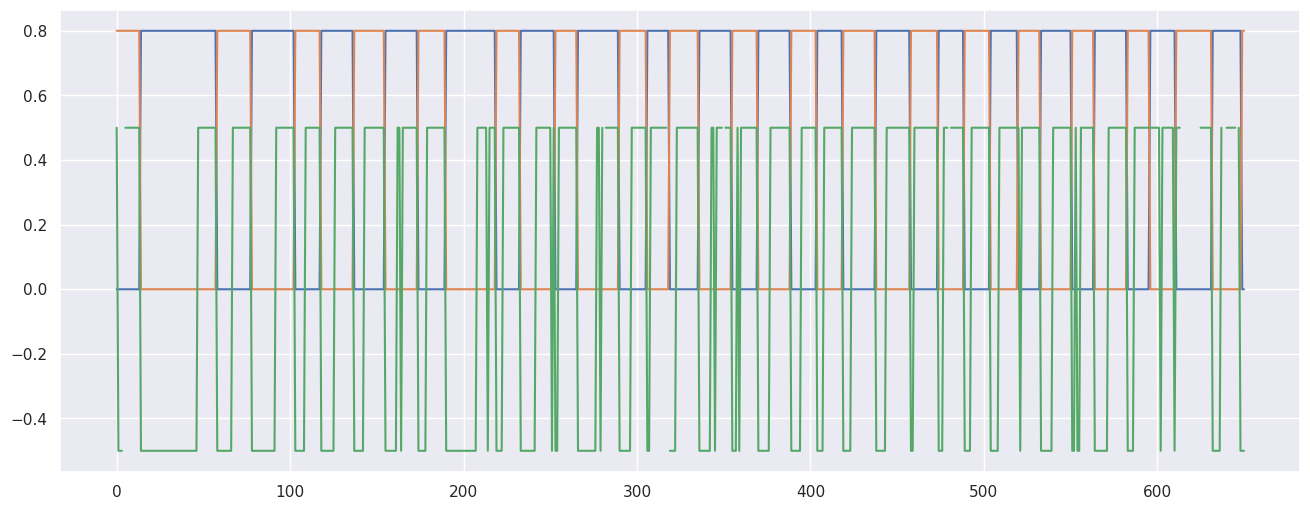

In [ ]:
reward_left = nwb.df_trials.reward_probabilityL.tolist()
reward_right = nwb.df_trials.reward_probabilityR.tolist()

chosen_metric = sample_df['chosen_metric'].tolist()

x = np.arange(0, len(sample_df['trial']))

plt.figure(figsize=(16,6))
plt.plot(x, reward_left)
plt.plot(x, reward_right)
plt.plot(x, chosen_metric)

plt.show()